# Radial mode regression

## Contents
* [Task description](#Task-description)
* [Dataset preprocessing](#Dataset-preprocessing)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further- development)

## Task description
To predict a position of the radial mode according to the pressure derivative vs time data.

## Dataset preprocessing

For training and model performance assessment we use pressure derivative from two types of wells - VS and GRP.

Dataset consists of two parts: train (311 items) and test (90 items).

Each one consists of:
* an array of the pressure derivative of different length
* an array of times when the above measurements were taken
* a type of a pattern determined by an expert for some of the itemes
* a well type
* a position of the radial mode

Some imports:

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(".."))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action, inbatch_parallel
from radial.batchflow.models.tf import TFModel
from radial.batchflow.models.tf.layers import conv_block

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch, RadialImagesBatch
from radial.core.radial_batch_tools import *

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

Dataset loading

In [2]:
train_data = Dataset(FilesIndex(path="./data_splited/train/*"), batch_class=RadialBatch)
test_data = Dataset(FilesIndex(path="./data_splited/test/*"), batch_class=RadialBatch)

We load data to an instance of Dataset class from Batchflow

In [7]:
sample_data = train_data.p.load(fmt='npz').next_batch(10)

In [8]:
sample_data.components

('time', 'derivative', 'rig_type', 'target', 'predictions')

Some examples of the initial data

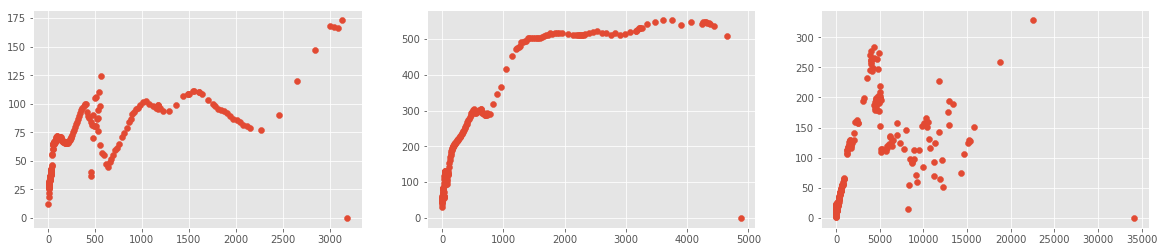

In [38]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

Pressure derivative data is noisy so we denoised the data beforehand using unsupervised method [Isolation forest](link). Сomparison of different approaches is [here](link)

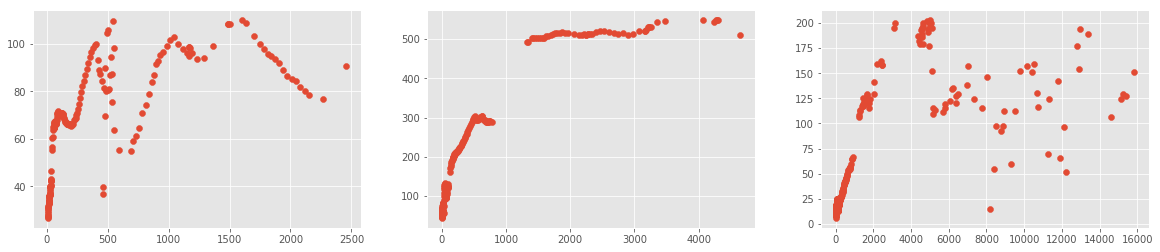

In [42]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)
sample_data = ds_train.p.load(fmt='npz').next_batch(10)

_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

As you can see algorithm removed some of the single distant outliers that are not informative.

Distribution of radial mode value for train and test data:

In [50]:
train = ds_train.p.load(fmt='npz').next_batch(len(ds_train))
test = ds_train.p.load(fmt='npz').next_batch(len(ds_test))

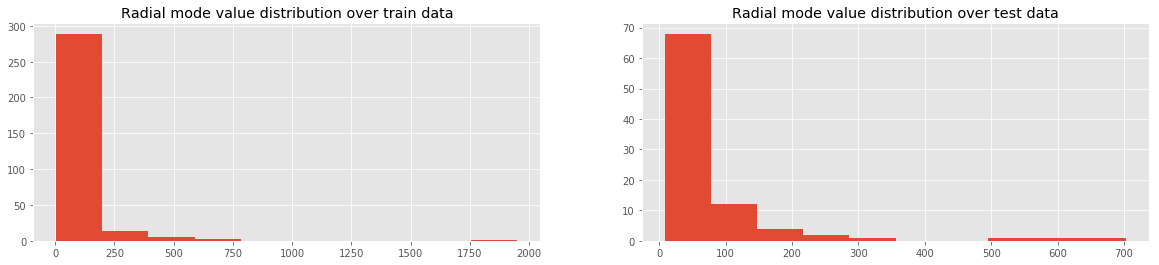

In [59]:
_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].hist(train.target)
ax[0].set_title("Radial mode value distribution over train data")
ax[1].hist(test.target)
ax[1].set_title("Radial mode value distribution over test data")
plt.show()

Scale of the pressure derivative (and consequently the radial mode values) is different across different wells. Therefore in preprocessing pipeline we
normalize the pressure derivative data, time and radial mode value to the range [0, 1] by substracting min value and dividing by max-min.
Also we take logarithm of the pressure derivative, time and radial mode value and perform piece-wise interpolation to sample an equal number of points
to feed the model.

The whole preprocessing pipeline:

In [4]:
GRID_SIZE = 200

preprocess_ppl = (Pipeline()
                .init_variable('loss_history_dict', init_on_each_run=0)
                .hard_negative_sampling(statistics_name='loss_history_dict', fraction=0.33)
                .load(fmt='npz')
                .drop_negative()
                .apply_transform(log, src=['time', 'derivative', 'target'], dst=['log_time', 'log_derivative', 'log_target'])
                .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                           dst_range=[None, 'derivative_range'])
                .normalize(src='log_target', dst='log_norm_target', src_range='derivative_range')
                .expand_dims(src='log_norm_target')
                .make_grid_data(src=['log_norm_time', 'log_norm_derivative'], dst=['log_norm_time_grid', 'log_norm_derivative_grid'],
                                grid_size=GRID_SIZE)
                .make_array(src='log_norm_derivative_grid', dst='derivative_grid')
           )

## Model architecture

We use a convolutional neural network consisting of 3 identical blocks.
The network architecture can be described by layout `cna cna cna Pf`, where letters correspond to the following layers:
* `с` - 1d convolution
* `n` - batch normalisation
* `a` - activation
* `P` - global average pooling
* `f` - dense

Convolutional layer parameters `c`:
* ```filters```= 64 * 2**i, where i - block number, i=0, 1, 2.
* ```kernel_size``` = 3
* ```strides``` = 2
* ```padding``` = 'same'
* ```data_format``` = 'channels_last'
* ```activation``` = `None`

Pooling layer parameters `p`:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation layer parameters `a`:
* `activation` = `tf.nn.relu`

Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

In [6]:
model_config = {
    'inputs': dict(signals=dict(shape=(GRID_SIZE, 1)),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cna cna cna', filters=[64, 128, 256],
                 strides=2, kernel_size=3),    
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'signals',
    'loss': 'mse',
    'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5})}

## Selection of hyperparameters

The choice of this architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](https://github.com/analysiscenter/standards/blob/model/model_examples/classification_model/parameters_estimation.ipynb).

Other parameters such as an activation function and single block layout are chosen due to the common standards. 

## Training

We train our model using stochastic gradient descent. On each iteration we
* load mini-batch data
* update the weights 

Algorith of weights update (optimizer) is the Nesterov momentum with hyperparameters:
* ```learning_rate``` = 0.01
* ```mu``` = 0.5

The choice of optimizer hyperparameters is motivated by the [research](../../research_examples/model_training/optimizer_search.ipynb), as for they show the best convergence.

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 64
* ```n_epochs``` = 10.

Training pipeline:

In [188]:
train_ppl = (preprocess_ppl 
                 .init_variable('loss')
                 .init_variable('mean_loss_history', init_on_each_run=list)
                 .init_variable('loss_history', init_on_each_run=0)
                 .init_model('dynamic', TFModel, 'model', config=model_config)
                 .train_model('model', fetches=['loss', 'TFModel/mean_squared_error/SquaredDifference:0'],
                           feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')},
                           save_to=[V('loss'), V('loss_history')], mode='w')
                 .update_variable('mean_loss_history', V('loss'), mode='a')
                 .update_loss_history_dict() << ds_train
                 )

In [382]:
test_ppl = (preprocess_ppl + 
                 Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', train_ppl)
                  .predict_model('model', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                      'labels': B('log_norm_target')}, 
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                  .clip_values(src='predictions', dst='predictions')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('targets', B('log_target'), mode='e')
                  .update_variable('predictions', B('denorm_predictions'), mode='e') << ds_test
                )

Execute training

In [189]:
train_ppl.reset_iter()
test_ppl.reset_iter()

In [190]:
BATCH_SIZE = 16

for i in range(2000):
    train_ppl.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
    test_ppl.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
print('done')

done


The loss function vs number of iterations:

In [192]:
len(train_ppl.get_variable('mean_loss_history'))

2000

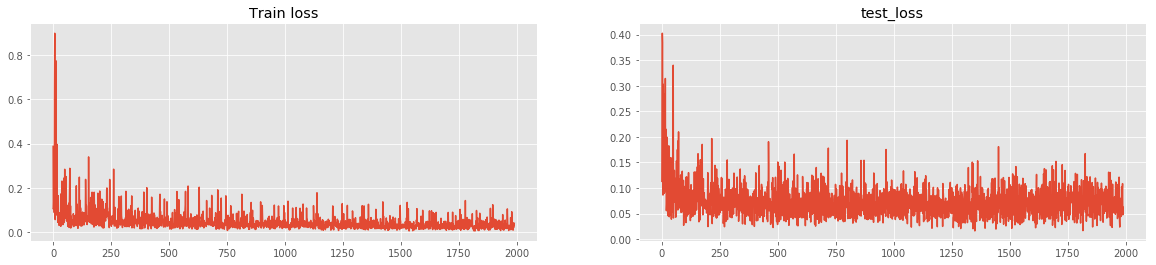

In [193]:
_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_ppl.get_variable('mean_loss_history')[10:])
ax[0].set_title("Train loss")
ax[1].plot(test_ppl.get_variable('loss_history')[10:])
ax[1].set_title("test_loss")
plt.show()

## Inference

Prediction pipeline:

In [376]:
predict_template = (preprocess_ppl 
                  .init_variable('targets', init_on_each_run=list)
                  .init_variable('predictions', init_on_each_run=list)
                  .import_model('model', train_ppl)
                  .predict_model('model', fetches='predictions',
                               feed_dict={'signals': B('derivative_grid')},
                               save_to=B('predictions'), mode='w')
                  .clip_values(src='predictions', dst='predictions')
                  .denormalize(src='predictions', dst='denorm_predictions',
                               src_range='derivative_range')
                  .update_variable('predictions', B('denorm_predictions'), mode='e') << ds_test
                )

Execute prediction pipeline

In [377]:
predict_ppl = predict_template << ds_test

In [378]:
btch = predict_ppl.next_batch(3)

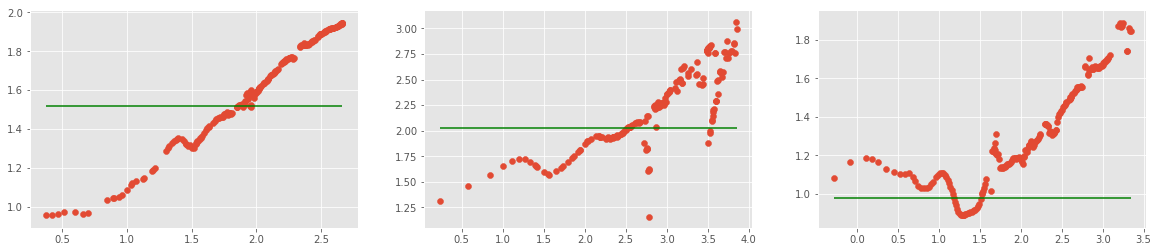

In [379]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[[ax[i].scatter(btch.log_time[i], btch.log_derivative[i]), \
  ax[i].hlines(btch.log_target[i], np.min(btch.log_time[i]), np.max(btch.log_time[i]), colors='g',
                   linestyle='-')] for i in range(3)]
plt.show()

## Model evaluation

Quality metric, in this case, is percentage of items with absolute percentage error less than 30% on the test set. We call it `test_mape30`

Metric evaluation:

In [383]:
test_ppl.reset_iter()
test_batch = test_ppl.next_batch(len(ds_test))
test_batch.target.shape

(90,)

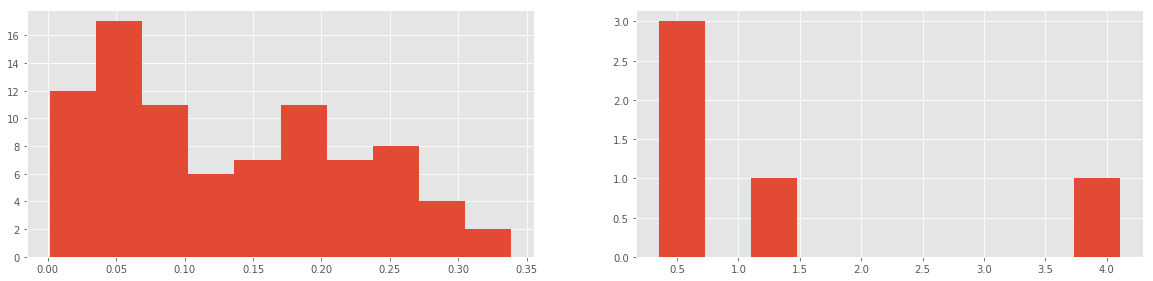

In [384]:
metrics = np.abs(test_batch.denorm_predictions.reshape(-1) - test_batch.log_target.reshape(-1)) / test_batch.log_target.reshape(-1)
metrics = metrics.astype(np.float32)

plt.figure(1, figsize=(20, 10))
plt.subplot(221)
plt.hist(np.sort(metrics)[:-5])
plt.subplot(222)
plt.hist(np.sort(metrics)[-5:])
plt.show()

In [385]:
print('Average metrics is', np.mean(metrics < 0.3) * 100)

Average metrics is 91.11111111111111


In [386]:
def draw_results(btch, ix, s=1):
    _, ax = plt.subplots(4, 3, figsize=(20, 12))
    ax = ax.reshape(-1)
    for i in range(s, s+12):
        ax[i-s].scatter(btch.log_time[ix][-i], btch.log_derivative[ix][-i], c='r')
        ax[i-s].hlines(btch.log_target[ix][-i], np.min(btch.log_time[ix][-i]), np.max(btch.log_time[ix][-i]), colors='g',
                   linestyle='-')
        ax[i-s].hlines(btch.denorm_predictions[ix][-i], np.min(btch.log_time[ix][-i]), 
                   np.max(btch.log_time[ix][-i]), colors='b', linestyle='-')
        
        ax[i-s].set_title('ape={0:.2f}, idx={1}'.format(metrics[ix][-i], btch.indices[ix][-i]))

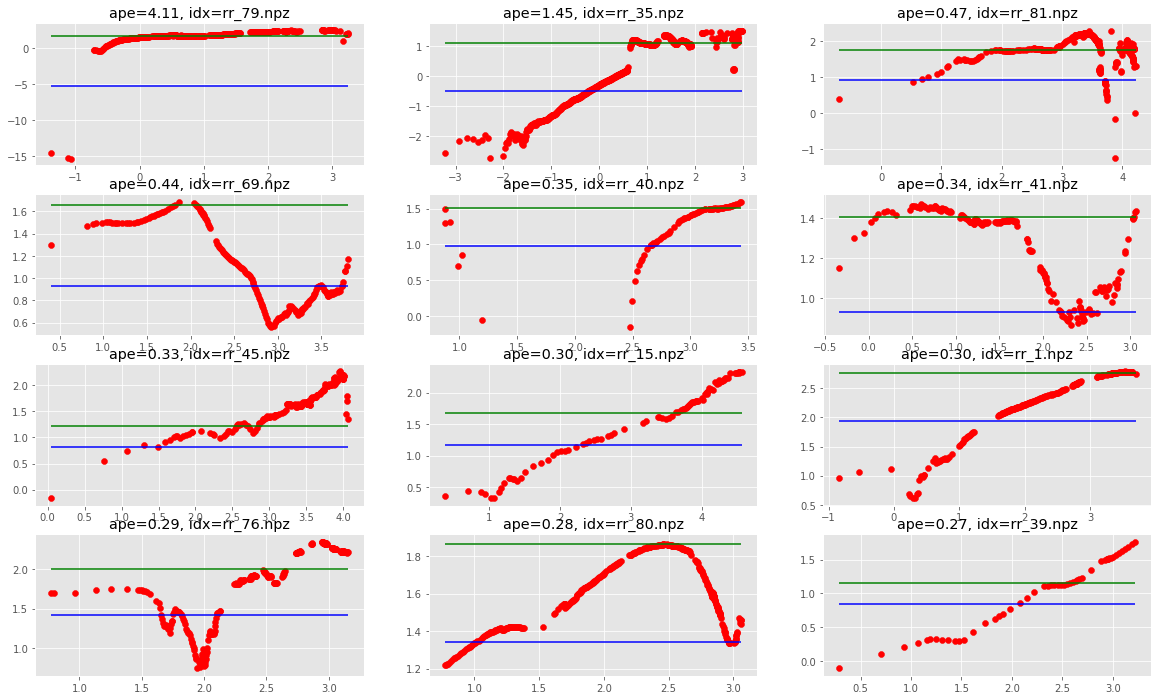

In [388]:
ix = np.argsort(metrics)
draw_results(test_batch, ix)

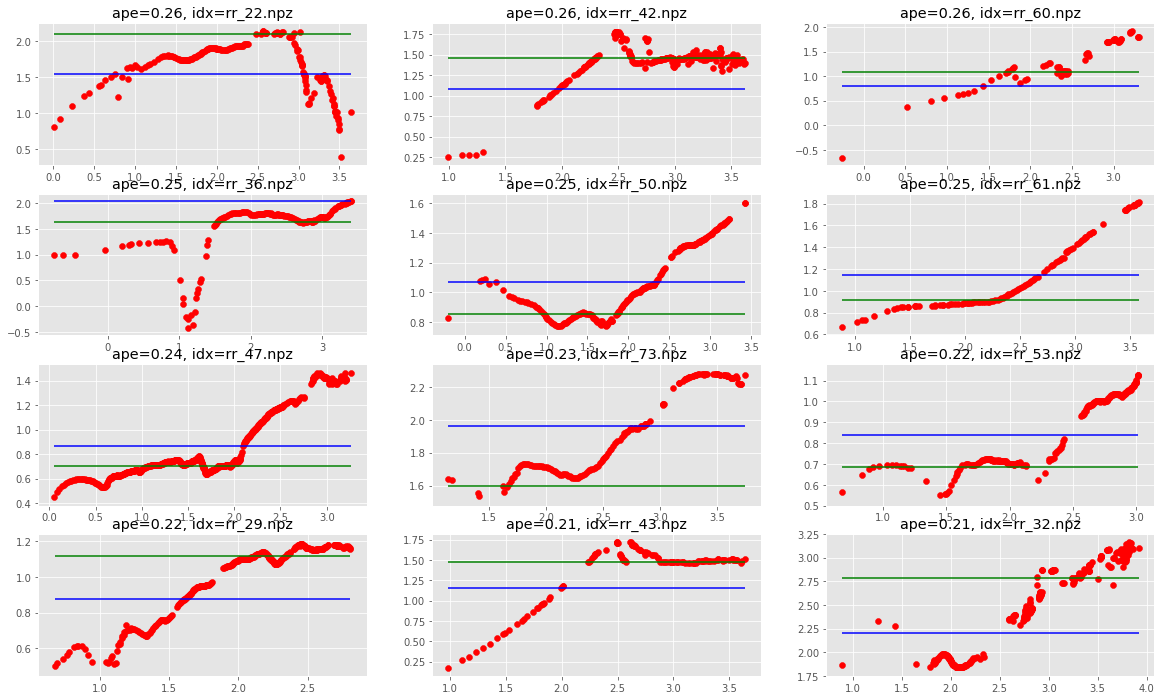

In [398]:
ix = np.argsort(metrics)
draw_results(test_batch, ix, s=13)

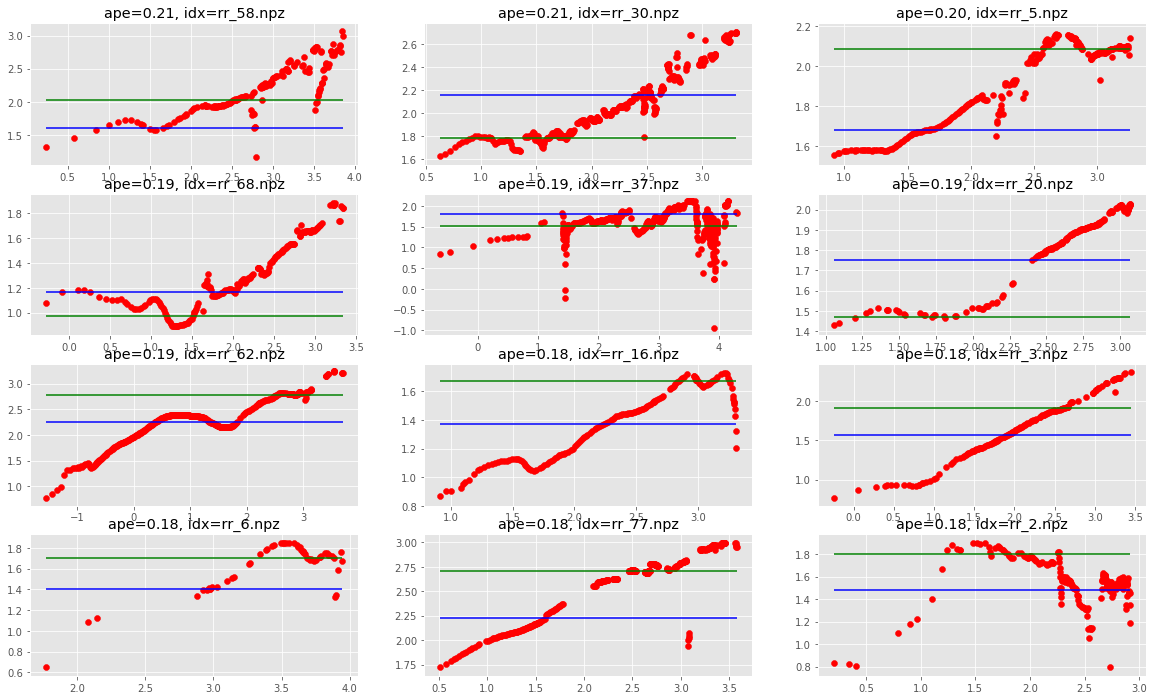

In [399]:
ix = np.argsort(metrics)
draw_results(test_batch, ix, s=25)

For model performance assessment an [experiment](./model_estimation.ipynb) was conducted on 10 model training launches from  scratch.

Research results loading and a distribution for `test_mape30`:

In [ ]:
res_table = Research().load('model_est_1/').load_results()
all_metrics = np.array(res_table[res_table['iteration']==1999][res_table['name']=='test_mape30']['metrics'], dtype=np.float32)

`Test_mape30` histogram

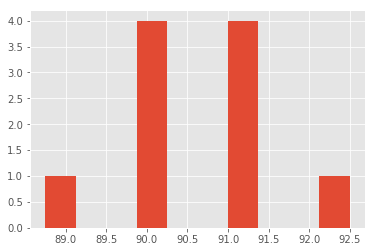

In [389]:
plt.hist(all_metrics)
plt.show()

In [390]:
print_results(research='model_est_1/', names=['test_mape30'], types_var=['metrics'], n_last=10)

╒════════════════════════╤═══════════════╕
│ params                 │   test_mape30 │
╞════════════════════════╪═══════════════╡
│ '64', '23', '3', 'cna' │       91.9125 │
╘════════════════════════╧═══════════════╛


Average value (median): 91.9125

## Operating time

Device: GPU NVIDIA 1080.

One train step on batch size 16 takes 246 ms. Training time for 102 epochs is 393 s.

One item inference takes 39 ms, for batch size 16 - 48 ms.

In [391]:
import time

In [392]:
start_time = time.clock()
train_ppl.next_batch(16)
print(time.clock() - start_time)

0.2468250000001717


In [394]:
start_time = time.clock()
for i in range(2000):
    train_ppl.next_batch(BATCH_SIZE, n_epochs=None, drop_last=True, shuffle=True)
print(time.clock() - start_time)

393.5337500000005


In [395]:
start_time = time.clock()
predict_ppl.next_batch(1)
print(time.clock() - start_time)

0.038983999998890795


In [396]:
start_time = time.clock()
predict_ppl.next_batch(16)
print(time.clock() - start_time)

0.04827300000033574


## Summary

The model predicts a position of the radial mode according to the pressure derivative vs time data. The mean model metrics corresponding to a percentage of items with absolute percentage error less than 30% is 91.91%

## Proposals for the improvement and further development
